In [1]:
import matplotlib.pyplot as plt
from scipy import optimize
import matplotlib.transforms as mtransforms
from scipy import ndimage
import scipy.misc
import imageio

In [2]:
plt.rc('figure', figsize=(20.0, 4.0))

In [3]:
"""
ELSA Icicle Edge Detection Script designed to find the left and right edges of the icicle using OpenCV.
Performed using OpenCV thresholding then analyzing difference in brightness values of threshold.
There is only one function in this script, EdgeDetect. Use help(EdgeDetect) for more details.
"""

#Import required libraries
import cv2 as cv
import sys
import numpy as np


def EdgeDetect(imageloc,threshold=110,kernalsize=3,bound=20):
    '''
    ELSA Edge Detection Function. Takes the following arguments:
    imageloc as string: relative path to the icicle image for processing.
    threshold as int: Brightness threshold for OpenCV Thresholding. Defaults to 110.
    kernalsize as int: Kernal Size for OpenCV Blurring. Defaults to 3.
    bound as int: Upper and lower bounds for edge detection (relative to threshold) using OpenCV Canny. Defaults to 20.
    And returns the following:
    leftedge as list: Pixel locations for left icicle edge, from base to tip
    rightedge as list: Pixel locations for right icicle edge, from base to tip
    '''
    #Contract kernal size variable for ease of use
    k=kernalsize
    
    #Calculate lbound and ubound using threshold and bound.
    lbound = max(0,threshold-bound)
    ubound = min(255,threshold+bound)
    
    #Try reading the image file, returning an error if read fails
    try:
        img = cv.imread(filename = imageloc,flags = cv.IMREAD_GRAYSCALE)
    except:
        return str("No compatible image found at ",imageloc)
    
    #Gaussian Blur the icicle image
    blurred = cv.GaussianBlur(src = img, ksize = (k, k), sigmaX = 0.1)
    
    #Brightness threshold the blurred image to calculate outside edges.
    (t, mask) = cv.threshold(src = blurred, thresh = threshold, maxval = 255,type = cv.THRESH_BINARY)
    edges = cv.Canny(mask,lbound,ubound)
    
    #Initialize arrays for optimal memory usage.
    leftedge = list(np.zeros(len(edges)))
    rightedge = list(np.zeros(len(edges)))
    
    #Create ints for missed pixels (pixels where no edges can be found) and the ending pixel of the icicle.
    missedpix = 0
    endpix = 0
    
    #Iterate over the height of the image
    for i in range(0,len(edges)):
        
        #Check if 2 or more pixels have been missed
        if missedpix < 2:
            #If not, try to find the next edge, and save the pixels to the arrays
            try:
                edgedetection = np.nonzero(edges[i])[0]
                leftedge[i] = edgedetection[0]
                rightedge[i]= edgedetection[-1]
            #If fails, consider this a "missed" pixel
            except:
                missedpix += 1
                endpix = i
        #If 2 or more pixels have been missed, then stop iterating, since this is likely the end of the icicle.
        else:
            break
            
    #Remove array elements beyond the end of the icicle so the image can be easily reversed
    del leftedge[endpix-1:]
    del rightedge[endpix-1:]
        
    #Return the calculated edges
    return leftedge,rightedge

In [4]:
left, right = EdgeDetect('icicle_test_cut.png')

left = np.array(left)
right = np.array(right)

x = np.arange(1,len(left)+1)

mid = (left + right) / 2

zero = np.zeros(len(x))

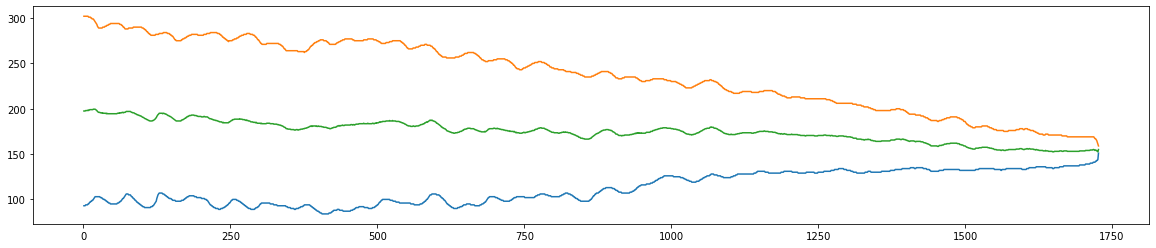

In [5]:
plt.plot(x, left)
plt.plot(x, right)
plt.plot(x, mid)
plt.show()

In [6]:
def midFunc(x, *p):
    return p[0] * x + p[1]

guesses = [-0.015, 200]

opt, cov = scipy.optimize.curve_fit(midFunc, x, mid, p0=guesses)

midFit = midFunc(x, *opt)

print(opt[0], '+/-', cov[0][0])
print(opt[1], '+/-', cov[1][1])

-0.021833379952172913 +/- 3.3550279392894445e-08
193.53167201010322 +/- 0.033383870258779286


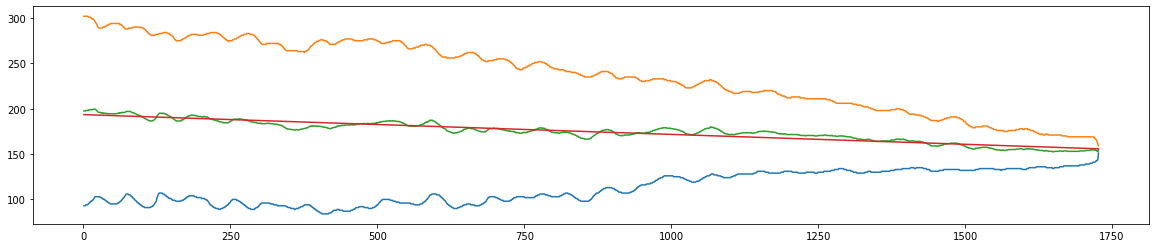

In [7]:
plt.plot(x, left)
plt.plot(x, right)
plt.plot(x, mid)
plt.plot(x, midFit)
plt.show()

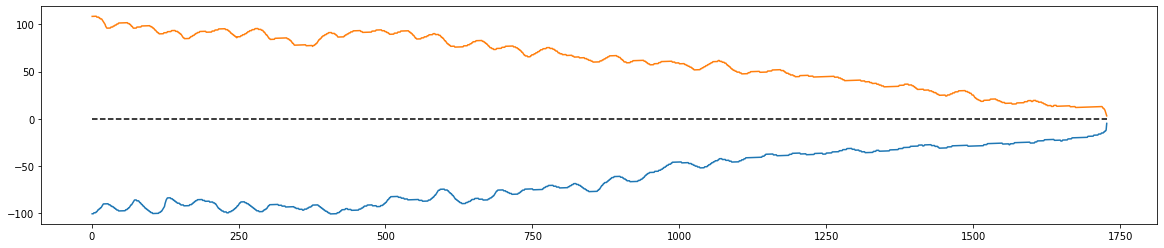

In [8]:
up = right - midFit
down = left - midFit

plt.plot(x, down)
plt.plot(x, up)
#plt.plot(x, zero, 'r')
plt.hlines(0, x[0], x[-1], linestyles='dashed')
plt.show()

a = 0.007872434946602414 +/- 3.527133031039966e-09


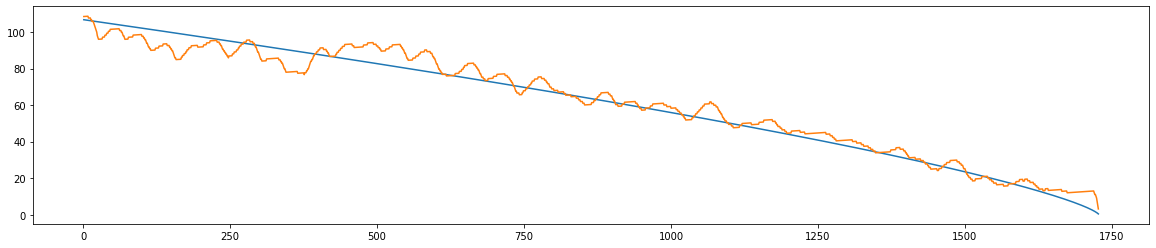

In [9]:
def distill(x):
    return 4 / 3 * (np.sqrt(x) + 2) * np.sqrt(np.sqrt(x) - 1)

def baseFunc(x, *p):
    a = p[0]
    return np.flip(distill(x / a) * a)

opt2, cov2 = scipy.optimize.curve_fit(baseFunc, x, up, p0=[0.01])

baseFit = baseFunc(x, *opt2)

print('a =', opt2[0], '+/-', cov2[0][0])

plt.plot(x, baseFit)
plt.plot(x, up)
plt.show()

a = 0.007830105367001702 +/- 6.958927688411569e-09


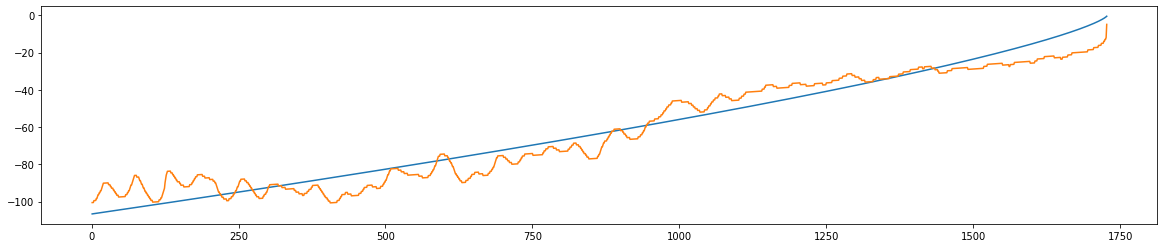

In [10]:
def baseFuncN(x, *p):
    a = p[0]
    return -1 * np.flip(distill(x / a) * a)

opt3, cov3 = scipy.optimize.curve_fit(baseFuncN, x, down, p0=[0.01])

baseFitN = baseFuncN(x, *opt3)

print('a =', opt3[0], '+/-', cov3[0][0])

plt.plot(x, baseFitN)
plt.plot(x, down)
plt.show()

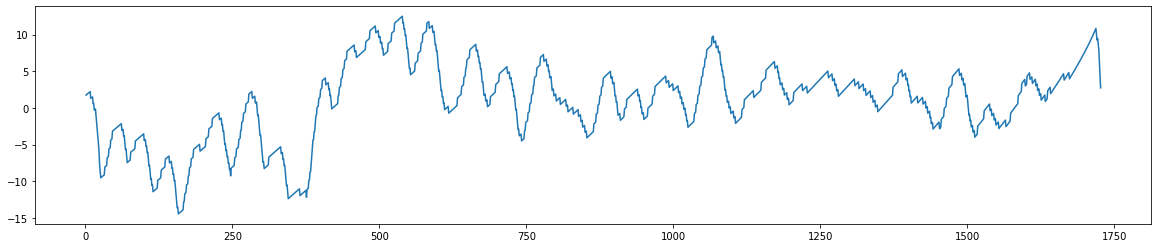

In [11]:
plt.plot(x, up-baseFit)
#plt.hlines(0, x[0], x[-1], linestyles='dashed')
plt.show()

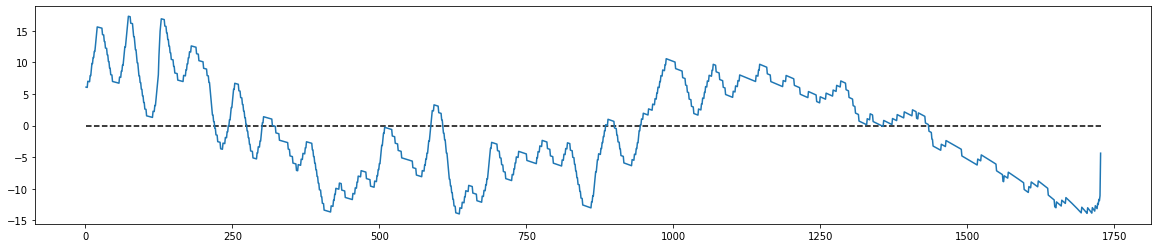

In [12]:
plt.plot(x, down-baseFitN)
plt.hlines(0, x[0], x[-1], linestyles='dashed')
plt.show()

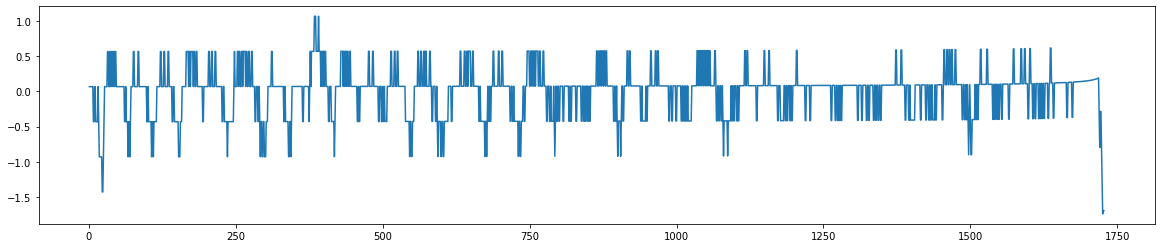

In [13]:
res_up = up - baseFit
grad_up = np.gradient(res_up)

plt.plot(x, grad_up)
plt.show()

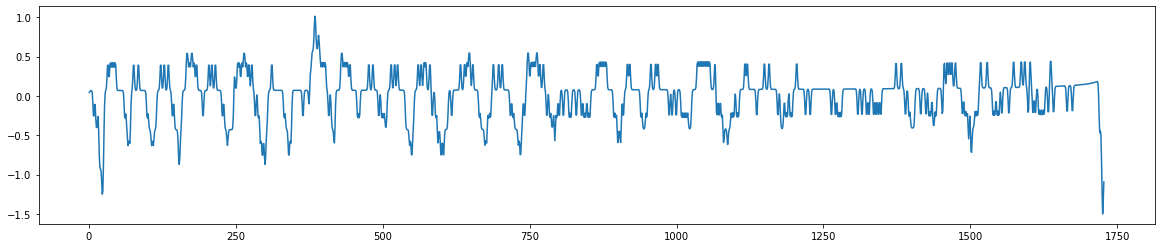

In [14]:
from scipy.ndimage import gaussian_filter

res_gf_up = gaussian_filter(res_up, sigma=1)
grad_gf_up = np.gradient(res_gf_up)

plt.plot(x, grad_gf_up)
plt.show()